In [24]:
import DataUtils.dubai_data_generator as ddg
import importlib
importlib.reload(ddg)
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import numpy
import torch
import numpy as np
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import pickle
import os
importlib.reload(ddg)
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Identity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


## Prepare datset

In [ ]:
class_names = ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled']

augmentations = transforms.Compose([
    transforms.ToTensor()
    ])
dataset_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'dubai_dataset')
dataset = ddg.DubaiDataset(dataset_path, transforms=augmentations)
class_names = dataset.get__class_names()
for class_name in class_names:
    print(dataset.get_image_count_for_class(class_name))

train_set, test_set, val_set = random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.1), int(len(dataset) * 0.1)])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

# Load saved resnet

In [ ]:
fine_tuned_model_file = os.path.join(os.path.join(os.getcwd()), 'fine_tuned_model.pth')
feature_extractor = models.resnet18(pretrained=True) 
num_classes = 4 

feature_extractor.fc = torch.nn.Linear(feature_extractor.fc.in_features, num_classes)
feature_extractor.load_state_dict(torch.load(fine_tuned_model_file))
feature_extractor.fc = nn.Identity()
feature_extractor.eval()


## Data preprocessing

In [27]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

feature_generator = feature_extractor

feature_generator.to(device)
feature_generator.eval()

def get_features_with_labels(device, feature_generator, loader):
    feature_generator.eval()
    model_without_fn_features = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader: 
            inputs = inputs.to(device)
            outputs = feature_generator(inputs)
            all_labels.extend(labels)
            model_without_fn_features.extend(outputs.cpu().tolist())
    return model_without_fn_features, all_labels

In [28]:

class DubaiFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, mode=None):
        self.features = np.array(features)
        self.labels = labels
        self.cov = np.cov(features, rowvar=False)
        self.means, self.stds = self.get_means_and_stds(self.features)
        
        match mode:
            case 'normalized':
                self.features = self.normalize_features(self.features, self.means, self.stds)
            case 'cdf':
                self.features = self.get_cdf(self.features, self.means, self.cov)
            case _:
                pass

    def __getitem__(self, index):
        features = np.array(self.features[index])
        features = np.float32(features)

        return features, self.labels[index]

    def __len__(self):
        return len(self.features)
    
    def get_means_and_stds(self, features):
        means = []
        stds = []
        for i in range(features.shape[1]):
            idx = features[:, i] != 0
            means.append(np.mean(features[idx, i]))
            stds.append(np.std(features[idx, i]))
        stds[stds == 0] = 1
        return means, stds
    
    def get_cdf(self, x, mean, cov):
        cdf = np.empty(x.shape)
        for i in range(x.shape[1]):
            cdf[:,i] = multivariate_normal.cdf(x[:,i], mean=mean[i], cov=cov[i,i], allow_singular=True)
        return cdf
    
    def normalize_features(self, outputs, means, stds):
        for i, (mean, std) in enumerate(zip(means, stds)):
            outputs = np.array(outputs)
            if std == 0:
                continue
            outputs[:, i] = (outputs[:, i] - mean) / std
        return outputs

In [6]:
def normalize_features(outputs, means, stds):
    for i, (mean, std) in enumerate(zip(means, stds)):
        outputs = np.array(outputs)
        if std == 0:
            continue
        outputs[:, i] = (outputs[:, i] - mean) / std
    return outputs

In [ ]:
train_features, train_labels = get_features_with_labels(device, feature_generator, train_loader)
feature_train_set = DubaiFeatureDataset(train_features, train_labels)
feature_train_loader = DataLoader(feature_train_set, batch_size=32, shuffle=True)

val_features, val_labels = get_features_with_labels(device, feature_generator, val_loader)
feature_val_set = DubaiFeatureDataset(val_features, val_labels)
feature_val_loader = DataLoader(feature_val_set, batch_size=32, shuffle=True)

test_features, test_labels = get_features_with_labels(device, feature_generator, test_loader)
test_feature_set = DubaiFeatureDataset(test_features, test_labels)
test_feature_loader = DataLoader(test_feature_set, batch_size=32, shuffle=False)

In [ ]:
train_features, train_labels = get_features_with_labels(device, feature_generator, train_loader)
normalized_feature_train_set = DubaiFeatureDataset(train_features, train_labels, mode='normalized')
normalized_feature_train_loader = DataLoader(normalized_feature_train_set, batch_size=32, shuffle=True)

val_features, val_labels = get_features_with_labels(device, feature_generator, val_loader)
normalized_feature_val_set = DubaiFeatureDataset(val_features, val_labels, mode='normalized')
normalized_feature_val_loader = DataLoader(normalized_feature_val_set, batch_size=32, shuffle=True)


test_features, test_labels = get_features_with_labels(device, feature_generator, test_loader)
normalized_test_feature_set = DubaiFeatureDataset(test_features, test_labels, mode='normalized')
normalized_test_feature_loader = DataLoader(normalized_test_feature_set, batch_size=32, shuffle=False)

In [ ]:
train_features, train_labels = get_features_with_labels(device, feature_generator, train_loader)
cdf_feature_train_set = DubaiFeatureDataset(train_features, train_labels, mode='cdf')
cdf_feature_train_loader = DataLoader(cdf_feature_train_set, batch_size=32, shuffle=True)

val_features, val_labels = get_features_with_labels(device, feature_generator, val_loader)
cdf_feature_val_set = DubaiFeatureDataset(val_features, val_labels, mode='cdf')
cdf_feature_val_loader = DataLoader(cdf_feature_val_set, batch_size=32, shuffle=True)

test_features, test_labels = get_features_with_labels(device, feature_generator, test_loader)
cdf_test_feature_set = DubaiFeatureDataset(test_features, test_labels, mode='cdf')
cdf_feature_test_loader = DataLoader(cdf_test_feature_set, batch_size=32, shuffle=True)

## Training model with new dataset

In [30]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [31]:
def one_hot_encode(y, num_classes):
    return torch.eye(num_classes)[y]

# Define model
class NeuralNetworkModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(512, 128)
        
        self.l2 = nn.Linear(128, 6)
    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


model = NeuralNetworkModel()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, feature_train_loader, feature_val_loader, criterion, optimizer):
    model.to(device)
# Training loop
    early_stopper = EarlyStopper(patience=3, min_delta=0.1)
    metrics_list = []
    for epoch in range(30):
        model.train()
        train_loss_values = []
        corrects = 0
        for X_batch, y_batch in feature_train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            y_batch = y_batch.squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            outputs = outputs.argmax(dim=1)
            y_batch = y_batch.argmax(dim=1)
        
            corrects += np.sum((outputs.cpu() == y_batch.cpu()).numpy())
            train_loss_values.append(loss.item())
        epoch_train_accuracy = corrects/len(train_set)
        epoch_train_loss_values = np.mean(train_loss_values)

        model.eval()
        val_loss_values = []
        corrects = 0
        for X_batch, y_batch in feature_val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            y_batch = y_batch.squeeze()
            loss = criterion(outputs, y_batch)
            outputs = outputs.argmax(dim=1)
            y_batch = y_batch.argmax(dim=1)
        
            corrects += np.sum((outputs.cpu() == y_batch.cpu()).numpy())
            val_loss_values.append(loss.item())
        epoch_val_accuracy = corrects/len(val_set)
        epoch_val_loss = np.mean(val_loss_values)
        metrics_list.append([epoch_train_accuracy, epoch_train_loss_values, epoch_val_accuracy, epoch_val_loss])
        print(f"Epoch {epoch+1}/{30}, train_loss: {epoch_train_loss_values:.4f}, train_accuracy: {epoch_train_accuracy:.4f}, val_loss: {epoch_val_loss:.4f}, val_accuracy: {epoch_val_accuracy:.4f}")
        
        if early_stopper.early_stop(epoch_val_loss):             
            break
    return model, metrics_list
    

In [ ]:
model = NeuralNetworkModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model1, metrics_list = train_model(model, feature_train_loader, feature_val_loader, criterion, optimizer)

with open('SavedVariables/m2_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_list, f)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = NeuralNetworkModel()
model2, metrics_list = train_model(model, normalized_feature_train_loader, normalized_feature_val_loader, criterion, optimizer)

with open('SavedVariables/m2_metrics_normalized.pkl', 'wb') as f:
    pickle.dump(metrics_list, f)

In [12]:
model = NeuralNetworkModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model3, metrics_list = train_model(model, cdf_feature_train_loader, cdf_feature_val_loader, criterion, optimizer)

with open('SavedVariables/m2_metrics_cdf.pkl', 'wb') as f:
    pickle.dump(metrics_list, f)

Epoch 1/30, train_loss: 0.4980, train_accuracy: 0.8335, val_loss: 0.4267, val_accuracy: 0.8602
Epoch 2/30, train_loss: 0.4117, train_accuracy: 0.8652, val_loss: 0.3770, val_accuracy: 0.8786
Epoch 3/30, train_loss: 0.3825, train_accuracy: 0.8740, val_loss: 0.3687, val_accuracy: 0.8820
Epoch 4/30, train_loss: 0.3649, train_accuracy: 0.8820, val_loss: 0.3506, val_accuracy: 0.8910
Epoch 5/30, train_loss: 0.3530, train_accuracy: 0.8875, val_loss: 0.3490, val_accuracy: 0.8884
Epoch 6/30, train_loss: 0.3440, train_accuracy: 0.8887, val_loss: 0.3392, val_accuracy: 0.8902
Epoch 7/30, train_loss: 0.3386, train_accuracy: 0.8909, val_loss: 0.3438, val_accuracy: 0.8930
Epoch 8/30, train_loss: 0.3320, train_accuracy: 0.8935, val_loss: 0.3260, val_accuracy: 0.8988
Epoch 9/30, train_loss: 0.3271, train_accuracy: 0.8952, val_loss: 0.3150, val_accuracy: 0.8994
Epoch 10/30, train_loss: 0.3226, train_accuracy: 0.8970, val_loss: 0.3207, val_accuracy: 0.9002
Epoch 11/30, train_loss: 0.3174, train_accuracy: 

## Evaluating model

In [34]:
def test_model(model, dataloader):
    model.eval()
    predictions = []
    labels = []
    corrects = 0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        y_batch = y_batch.squeeze()
        outputs = outputs.argmax(dim=1)
        y_batch = y_batch.argmax(dim=1)
        predictions.extend(outputs.cpu())
        labels.extend(y_batch.cpu())
        corrects += np.sum((outputs.cpu() == y_batch.cpu()).numpy())
    return predictions, labels


In [20]:
predictions, labels = test_model(model3, cdf_feature_test_loader)

In [ ]:

def get_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix
    }

# Example usage
metrics = get_classification_metrics(labels, predictions)

In [37]:
metrics

{'Accuracy': 0.7918,
 'Precision': 0.7364493293063117,
 'Recall': 0.7918,
 'F1 Score': 0.7605005064388486,
 'Confusion Matrix': array([[ 612,   92,    0,   72,    1,    0],
        [  48, 1770,    0,   47,   10,    0],
        [  20,   90,    0,  178,   16,    0],
        [  28,   31,    0,  384,  339,    0],
        [   0,   14,    0,   31, 1193,    0],
        [   9,   13,    0,    1,    1,    0]])}

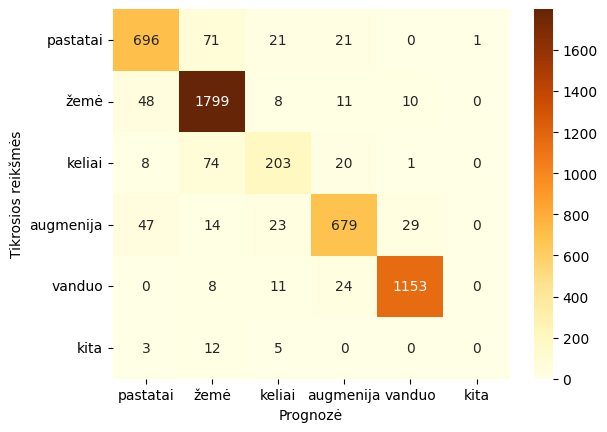

In [19]:
matrix = metrics['Confusion Matrix']
display_labels = [ "pastatai", "žemė", "keliai", "augmenija", "vanduo", "kita"]
sns.heatmap(matrix, cmap='YlOrBr', annot=True, fmt='g', xticklabels=display_labels, yticklabels=display_labels)
plt.xlabel('Prognozė')
plt.ylabel('Tikrosios reikšmės')
plt.show()